In [1]:
import jax.numpy as jnp
from jax import jit, grad, vmap
import matplotlib.pyplot as plt
import numpy as np
from jax import random
from jax import jit, jacfwd, lax, jacrev, hessian

key = random.PRNGKey(0)
print(f"{key = }")

key = Array([0, 0], dtype=uint32)


In [2]:
# def reference_function1(t):
#     """Trajectory to track"""
#     return np.array([0., 0., -3., 0.]).reshape((4,1))

# def reference_function2(t):
#     """Trajectory to track"""
#     return np.array([np.sin(t), np.cos(t), -3., 0.]).reshape((4,1))

# def reference_function3(x10, t):
#     """Trajectory to track"""
#     return np.array([0., 0., -(2 + np.sin(t), 0.)]).reshape((4,1))

# def reference_function4(t):
#     """Trajectory to track"""
#     return np.array([np.sin(t), np.cos(t), -(2 + np.sin(t)), t % 2*np.pi]).reshape((4,1))

# def reference_function5(t):
#     """Trajectory to track"""
#     PERIOD = 5
#     w = 2*np.pi / PERIOD
#     return np.array([.35*np.sin(2*w*t), .35*np.sin(w*t), -(2 + np.sin(w*t)), 0]).reshape((4,1))

def reference_function1(t):
    """Trajectory to track"""
    return np.array([3.0]).reshape((-1,1))

def reference_function2(t):
    """Trajectory to track"""
    period = 1
    w = 2*np.pi / period
    return np.array([np.sin(w*t)]).reshape((-1,1))

def reference_function3(x10, t):
    """Trajectory to track"""
    return np.array([x10 + t]).reshape((-1,1))

def reference_function4(t):
    """Trajectory to track"""
    return np.array([np.sin(t)*np.cos(2*np.pi*3)]).reshape((-1,1))

In [3]:
reffunc = reference_function1

In [4]:
# Simulation parameters
T = 10.0  # Time Horizon of simulation
SIM_STEP = 0.01  # Time step of simulation
T_lookahead = 0.8  # Time horizon for Control
INTEGRATION_STEP = 0.1
NOISE_SCALING = 0.001
C = jnp.array([[1, 0,]])

MASS = 1.75
GRAVITY = 9.81

ref0 = reffunc(0.0+T_lookahead)

x10 = 0.0  # initial state
x20 = 0.0  # initial state
x30 = -0.2  # initial state
state0 = jnp.array([x10, x20]).reshape((-1,1))

u0_thrust = 0.0
input0 = jnp.array([u0_thrust])

error0 = ref0 - C@state0

i = 0

In [5]:
print(f"{input0.shape = }")
print(f"{state0.shape = }")

input0.shape = (1,)
state0.shape = (2, 1)


In [6]:
# Logs
states = np.zeros((int(T/SIM_STEP), len(state0)))
inputs = np.zeros((int(T/SIM_STEP), len(input0)))
refs = np.zeros((int(T/SIM_STEP), len(ref0)))
errors = np.zeros((int(T/SIM_STEP), len(ref0)))
ts = np.zeros((int(T/SIM_STEP), 1))

# log initial values
states[i] = state0.flatten().tolist()
inputs[i] = input0.flatten().tolist()
refs[i] = ref0.flatten().tolist()
errors[i] = error0.flatten().tolist()
ts[i] = 0.0


In [7]:
from jax import debug

@jit
def dynamics(state, input):
    """Compute the state derivative."""
    x1, x2 = state
    u = input.flatten()
    # print(f"{x1 = }")
    # print(f"{x2 = }")
    # print(f"{u = }")
    # print(f"{x1.shape = }")
    # print(f"{x2.shape = }")
    # print(f"{u.shape = }")
    x1d = u**3
    x2d = -x2
    print(f"{x1d = }")
    print(f"{x2d = }")


    xdot = jnp.array([x1d, x2d]).reshape((-1,1))
    print(f"{xdot = }")

    return xdot


# @jit
def get_next_state(state, u, timestep, key):
    """Update state using the dynamics."""
    key, subkey = random.split(key)
    # print(f"{state =}")
    # print(f"{u = }")
    dxdt = dynamics(state, u)
    print(f"{dxdt = }")
    noise = NOISE_SCALING * random.uniform(key, (len(state0),1), minval=-0.2, maxval = 0.2)
    x_next = state + dxdt * timestep + noise
    return x_next, key


In [8]:
next_state, key = get_next_state(state0, input0, SIM_STEP, key)
print(f"{next_state.shape = }")
print(f"{key = }")

x1d = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
x2d = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
xdot = Traced<ShapedArray(float32[2,1])>with<DynamicJaxprTrace(level=1/0)>
dxdt = Array([[ 0.],
       [-0.]], dtype=float32)
next_state.shape = (2, 1)
key = Array([4146024105,  967050713], dtype=uint32)


In [9]:
@jit
def fwd_euler(state, input, integration_step, integrations_int):
    """Forward Euler integration."""
    def for_function(i, current_state):
        return current_state + dynamics(current_state, input) * integration_step

    pred_state = lax.fori_loop(0, integrations_int, for_function, state)
    return pred_state

@jit
def predict_state(state, u, T_lookahead, integration_step):
    """Predict the next state."""
    # integrations_int = int(T_lookahead / integration_step)
    integrations_int = (T_lookahead / integration_step).astype(int)
    pred_state = fwd_euler(state, u, integration_step, integrations_int)
    return pred_state

@jit
def predict_output(state, u, T_lookahead, integration_step, C):
    """Predict the output."""
    pred_state = predict_state(state, u, T_lookahead, integration_step)
    return C @ pred_state


In [10]:

state0 + dynamics(state0, input0) * 0.1

Array([[0.],
       [0.]], dtype=float32)

In [11]:
aa = predict_state(state0, input0, T_lookahead, 0.1)
bb = fwd_euler(state0, input0, 0.1, 8)
cc = predict_output(state0, input0, T_lookahead, 0.1, C)
print(f"{aa = }")
print(f"{bb = }")
print(f"{cc = }")

aa = Array([[0.],
       [0.]], dtype=float32)
bb = Array([[0.],
       [0.]], dtype=float32)
cc = Array([[0.]], dtype=float32)


In [12]:
# get jacobian of predition with respect to input
@jit
def get_jac_pred_u(state, last_input, T_lookahead, integration_step, C):
    raw_val = jacfwd(predict_output, 1)(state, last_input, T_lookahead, integration_step, C)
    return raw_val.reshape((len(C),1))

@jit
def NR_tracker(currstate, currinput, ref, T_lookahead, integration_step, C, sim_step):
    """Newton-Raphson method to track the reference trajectory."""
    alpha = 20
    pred = predict_output(currstate, currinput, T_lookahead, integration_step, C)
    error = (ref - pred)

    print(f"{pred = }")
    print(f"{ref = }")
    print(f"{error = }")

    dgdu = get_jac_pred_u(currstate, currinput, T_lookahead, integration_step, C)
    dgdu_inv = jnp.linalg.inv(dgdu)
    # print(f"{dgdu = }")
    # print(f"{dgdu_inv = }")

    NR = dgdu_inv @ error
    # print(f"{NR = }")
    udot = alpha * NR
    print(f"{udot = }")

    change_u = udot * sim_step
    print(f"{change_u = }")

    print(f"{currinput = }")
    new_u = currinput + change_u
    return new_u


In [13]:
dgdu = get_jac_pred_u(state0, input0, 1.2, 0.1, C)
print(f"{dgdu = }")


dgdu = Array([[0.]], dtype=float32)


In [14]:
@jit
def error_func(state, u, T_lookahead, integration_step, C, ref):
    """Compute the error."""
    pred = predict_output(state, u, T_lookahead, integration_step, C)
    return jnp.sum((ref - pred)**2)

@jit
#get error func derivative wrt input
def get_grad_error_u(state, u, T_lookahead, integration_step, C, ref):
    return jacfwd(error_func, 1)(state, u, T_lookahead, integration_step, C, ref)

@jit
#get hessian of error func wrt input
def get_hess_error_u(state, u, T_lookahead, integration_step, C, ref):
    return jacfwd(get_grad_error_u, 1)(state, u, T_lookahead, integration_step, C, ref).reshape(len(C),len(u))


In [15]:
dgdu = get_grad_error_u(state0, input0, T_lookahead, 0.1, C, 3.0)
print(f"{dgdu = }")
hess = get_hess_error_u(state0, input0, T_lookahead, 0.1, C, 3.0)
print(f"{hess = }")

dgdu = Array([-0.], dtype=float32)
hess = Array([[0.]], dtype=float32)


In [16]:
@jit
def NR_tracker_2(currstate, currinput, ref, T_lookahead, integration_step, C, sim_step):
    """Newton-Raphson method to track the reference trajectory."""
    alpha = 20
    pred = predict_output(currstate, currinput, T_lookahead, integration_step, C)
    error = error_func(currstate, currinput, T_lookahead, integration_step, C, ref)
    print(f"{pred = }")
    print(f"{ref = }")
    print(f"{error = }")

    dgdu = get_grad_error_u(currstate, currinput, T_lookahead, integration_step, C, ref)
    hess = get_hess_error_u(currstate, currinput, T_lookahead, integration_step, C, ref)
    d2gdu2_inv = jnp.linalg.inv(hess)
    print(f"{dgdu = }")
    print(f"{hess = }")
    print(f"{d2gdu2_inv = }")

    scaling = d2gdu2_inv @ dgdu
    print(f"{scaling = }")
    NR = scaling
    udot = -alpha * NR
    print(f"{udot = }")

    change_u = udot * sim_step
    print(f"{change_u = }")

    print(f"{currinput = }")
    new_u = currinput + change_u
    print(f"{new_u = }")
    return new_u

In [17]:
jj = jnp.array([1.0])
print(f"{jj = }")
print(f"{jj.shape = }")

jj = Array([1.], dtype=float32)
jj.shape = (1,)


In [18]:
new_u = NR_tracker(state0, input0, 0.08, T_lookahead, 0.1, C, SIM_STEP)
print(f"{new_u = }")

pred = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
ref = Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
error = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
udot = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
change_u = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
currinput = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
new_u = Array([[inf]], dtype=float32)


In [19]:
new_u = NR_tracker_2(state0, input0, 0.08, T_lookahead, 0.1, C, SIM_STEP)
print(f"{new_u = }")

pred = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
ref = Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
error = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
dgdu = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
hess = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
d2gdu2_inv = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
scaling = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
udot = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
change_u = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
currinput = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
new_u = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
new_u = Array([nan], dtype=float32)


In [20]:
# Run simulation
i= 0
for t in jnp.arange(SIM_STEP, T, SIM_STEP):
    print(f"Iteration #{i} at {t} seconds")
    i+=1

    currstate = states[i-1].reshape((-1,1))
    currinput = inputs[i-1].reshape((-1,1))
    # print(f"{currstate= },\n{currinput= }")
    next_state, key = get_next_state(currstate, currinput, SIM_STEP, key)

    ref = reffunc((t+T_lookahead))
    # print(f"{ref = }")

    new_input = NR_tracker(currstate, currinput, ref, T_lookahead, INTEGRATION_STEP, C, SIM_STEP)
    # new_input = NR_tracker_2(currstate, currinput, ref, T_lookahead, INTEGRATION_STEP, C, SIM_STEP)
    print(f"{new_input = }")

    states[i] = next_state.flatten().tolist()
    inputs[i] = new_input.flatten().tolist()
    refs[i] = reffunc(t).flatten().tolist()
    errors[i] = (reffunc(t) - C@currstate).flatten().tolist()
    ts[i] = t
    print(f"\n")
    # if i >= 9:
    #     break    

Iteration #0 at 0.009999999776482582 seconds
x1d = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
x2d = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
xdot = Traced<ShapedArray(float32[2,1])>with<DynamicJaxprTrace(level=1/0)>
dxdt = Array([[ 0.],
       [-0.]], dtype=float32)
pred = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
ref = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
error = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
udot = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
change_u = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
currinput = Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=1/0)>
new_input = Array([[inf]], dtype=float32)


Iteration #1 at 0.019999999552965164 seconds
dxdt = Array([[        inf],
       [-0.00017309]], dtype=float32)
new_input = Array([[nan]], dtype=float32)


Iteration #2 at 0.02999999

In [21]:
# ts = np.arange(0, T, SIM_STEP)
x1s = states[:,0]
x2s = states[:,1]
# x3s = states[:,2]
# x4s = states[:,3]

r1s = refs[:,0]
# r2s = refs[:,1]
# r3s = refs[:,2]
# r4s = refs[:,3]

thrusts = inputs[:, 0]
# ps = inputs[:, 1]
# qs = inputs[:, 2]
# rs = inputs[:, 3]

In [22]:
rmse = np.sqrt(np.mean(errors**2))
print("Overall RMSE:", rmse)

Overall RMSE: nan


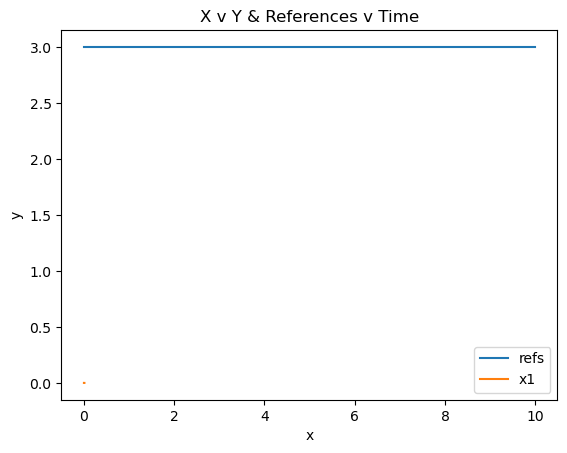

In [23]:
plt.figure(1)
plt.plot(ts, r1s, label="refs")
plt.plot(ts, x1s, label="x1")
plt.title("X v Y & References v Time")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()